In [71]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [72]:
# Paramètres du modèle de Hodgkin-Huxley
params_hodgkin_huxley = {
    'C_m': 1.0,    # Capacitance de la membrane par unité de surface (uF/cm^2)
    'g_Na': 120.0, # Conductance maximale des canaux sodium par unité de surface (mS/cm^2)
    'g_K': 36.0,   # Conductance maximale des canaux potassium par unité de surface (mS/cm^2)
    'g_L': 0.3,    # Conductance de fuite maximale par unité de surface (mS/cm^2)
    'E_Na': 50.0,  # Potentiel d'inversion du sodium (mV)
    'E_K': -77.0,  # Potentiel d'inversion du potassium (mV)
    'E_L': -54.387 # Potentiel d'inversion de fuite (mV)
}

In [73]:
# temps pour la simulation
t = np.arange(0.0, 450.0, 0.01)

# fonction définissant le courant entrant pour la simulation
def I_inj(t):
    return 5*(t>50) - 5*(t>100) + 15*(t>200) - 15*(t>250) + 30*(t>300) - 30*(t>350)

# valeurs initiales de courant global et pour chaque canal ionique
val_init = [-65, 0.05, 0.6, 0.32]

In [74]:
# créé à partir du modèle sur le site https://hodgkin-huxley-tutorial.readthedocs.io/en/latest/index.html
class HodgkinHuxley():
    """Full Hodgkin-Huxley Model implemented in Python"""

    def __init__(self, params):
        self.C_m  =   params['C_m']
        """membrane capacitance, in uF/cm^2"""

        self.g_Na = params['g_Na']
        """Sodium (Na) maximum conductances, in mS/cm^2"""

        self.g_K  =  params['g_K']
        """Postassium (K) maximum conductances, in mS/cm^2"""

        self.g_L  =   params['g_L']
        """Leak maximum conductances, in mS/cm^2"""

        self.E_Na =  params['E_Na']
        """Sodium (Na) Nernst reversal potentials, in mV"""

        self.E_K  = params['E_K']
        """Postassium (K) Nernst reversal potentials, in mV"""

        self.E_L  = params['E_L']
        """Leak Nernst reversal potentials, in mV"""

    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*np.exp(-(V+65) / 80.0)

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)

        |  :param V:
        |  :param m:
        |  :param h:
        |  :return:
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    @staticmethod
    def dALLdt(X, t, self, I_inj):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (I_inj(t) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dmdt, dhdt, dndt

    def simulation(self, t, val_init, I_inj):
        """
        Main demo for the Hodgkin Huxley neuron model
        """

        X = odeint(self.dALLdt, val_init, t, args=(self,I_inj))
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
        ina = self.I_Na(V, m, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)
    
        return {'V':V, 'm':m, 'h':h, 'n':n, 'ina':ina, 'ik':ik, 'il':il}


In [75]:
# Initialisation du modèle
hh = HodgkinHuxley(params_hodgkin_huxley)

# Exécution de la simulation
resultat = hh.simulation(t, val_init, I_inj)

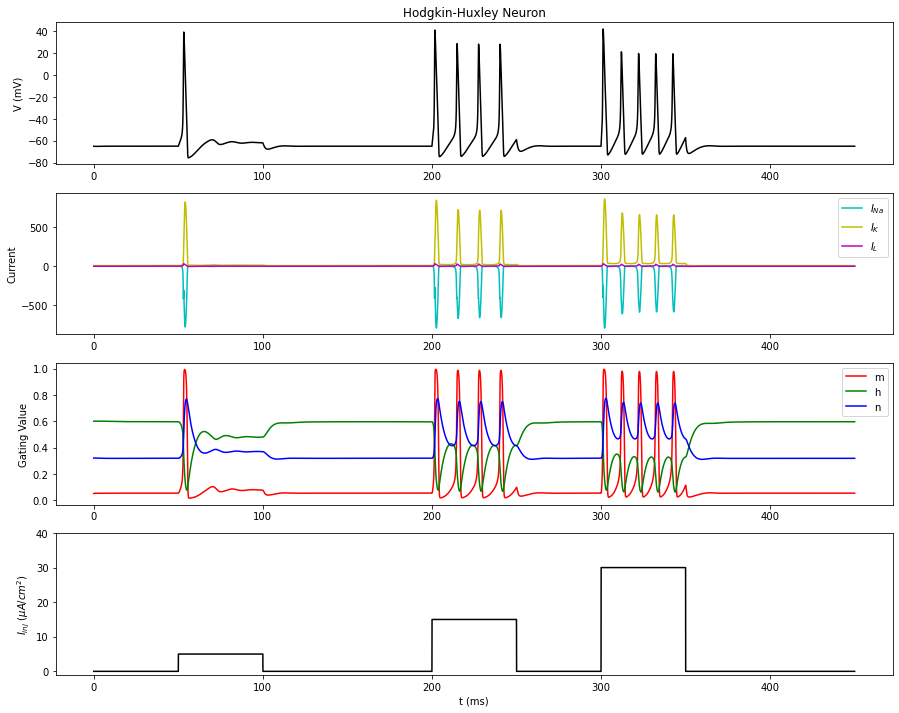

In [76]:
# Affiche les résultats de l'expérience
plt.figure(figsize=(15,12))

plt.subplot(4,1,1)
plt.title('Hodgkin-Huxley Neuron')
plt.plot(t, resultat['V'], 'k')
plt.ylabel('V (mV)')

plt.subplot(4,1,2)
plt.plot(t, resultat['ina'], 'c', label='$I_{Na}$')
plt.plot(t, resultat['ik'], 'y', label='$I_{K}$')
plt.plot(t, resultat['il'], 'm', label='$I_{L}$')
plt.ylabel('Current')
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, resultat['m'], 'r', label='m')
plt.plot(t, resultat['h'], 'g', label='h')
plt.plot(t, resultat['n'], 'b', label='n')
plt.ylabel('Gating Value')
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, I_inj(t), 'k')
plt.xlabel('t (ms)')
plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
plt.ylim(-1, 40)

plt.show()